# Neural style transfer
As part of Fast AI's challenge for students, I will be implementing neural style transfer. Given that I am training primarily on my M1 MacBook Pro's GPU (read: slow training), I may set some aspects to be easier to train (e.g. less epochs, less classes etc).

Let's have a go at it and see what happens.

In [1]:
import shutil,os,torch,random,datasets,math
import fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim
from torchvision import transforms
from torchvision.io import read_image,ImageReadMode
from glob import glob
from sklearn.model_selection import train_test_split
from IPython.display import display

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *
from miniai.training import *

In [2]:
from PIL import Image

In [3]:
from fastprogress import progress_bar

In [4]:
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['figure.dpi'] = 70

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## Data processing (style images)

In [7]:
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path = path_data/'tiny-best-artwork'

We need to split our data into train test folders.

In [6]:
data_prepped = True

In [7]:
if not data_prepped:
    for artist_folder in path.iterdir():
        if artist_folder.is_dir():
            files = list(glob(str(artist_folder/'*.jpg')))
            train_files, test_files = train_test_split(files, test_size=0.2)

            # Create `train` and `test` folders
            train_folder = artist_folder / 'train'
            test_folder = artist_folder / 'test'
            os.makedirs(train_folder, exist_ok=True)
            os.makedirs(test_folder, exist_ok=True)

            # Move files to `train` folder
            for train_file in train_files:
                shutil.move(train_file, train_folder / os.path.basename(train_file))

            # Move files to `test` folder
            for test_file in test_files:
                shutil.move(test_file, test_folder / os.path.basename(test_file))


In [8]:
bs = 128

### Prep `train_ds` and `val_ds`

In [9]:
class TinyDS:
    def __init__(self, path, train_or_test):
        self.path = Path(path)
        self.files = glob(str(self.path/f"*/{train_or_test}/*.jpg"), recursive=True)

    def __len__(self): return len(self.files)

    def __getitem__(self, i):
        return self.files[i], Path(self.files[i]).parent.parent.name

In [10]:
train_ds = TinyDS(path, "train")

In [11]:
len(train_ds)

1104

In [12]:
train_ds[0]

('data/tiny-best-artwork/Albrecht_Du╠êrer/train/Albrecht_Du╠êrer_14.jpg',
 'Albrecht_Du╠êrer')

In [13]:
train_ds[10]

('data/tiny-best-artwork/Albrecht_Du╠êrer/train/Albrecht_Du╠êrer_118.jpg',
 'Albrecht_Du╠êrer')

In [14]:
val_ds = TinyDS(path, "test")

In [15]:
len(val_ds)

279

In [16]:
val_ds[0]

('data/tiny-best-artwork/Albrecht_Du╠êrer/test/Albrecht_Du╠êrer_247.jpg',
 'Albrecht_Du╠êrer')

In [17]:
val_ds[30]

('data/tiny-best-artwork/Albrecht_Du╠êrer/test/Albrecht_Du╠êrer_237.jpg',
 'Albrecht_Du╠êrer')

### Make sure images are read correctly

In [18]:
img = Image.open("data/tiny-best-artwork/Albrecht_Du╠êrer/train/Albrecht_Du╠êrer_14.jpg")


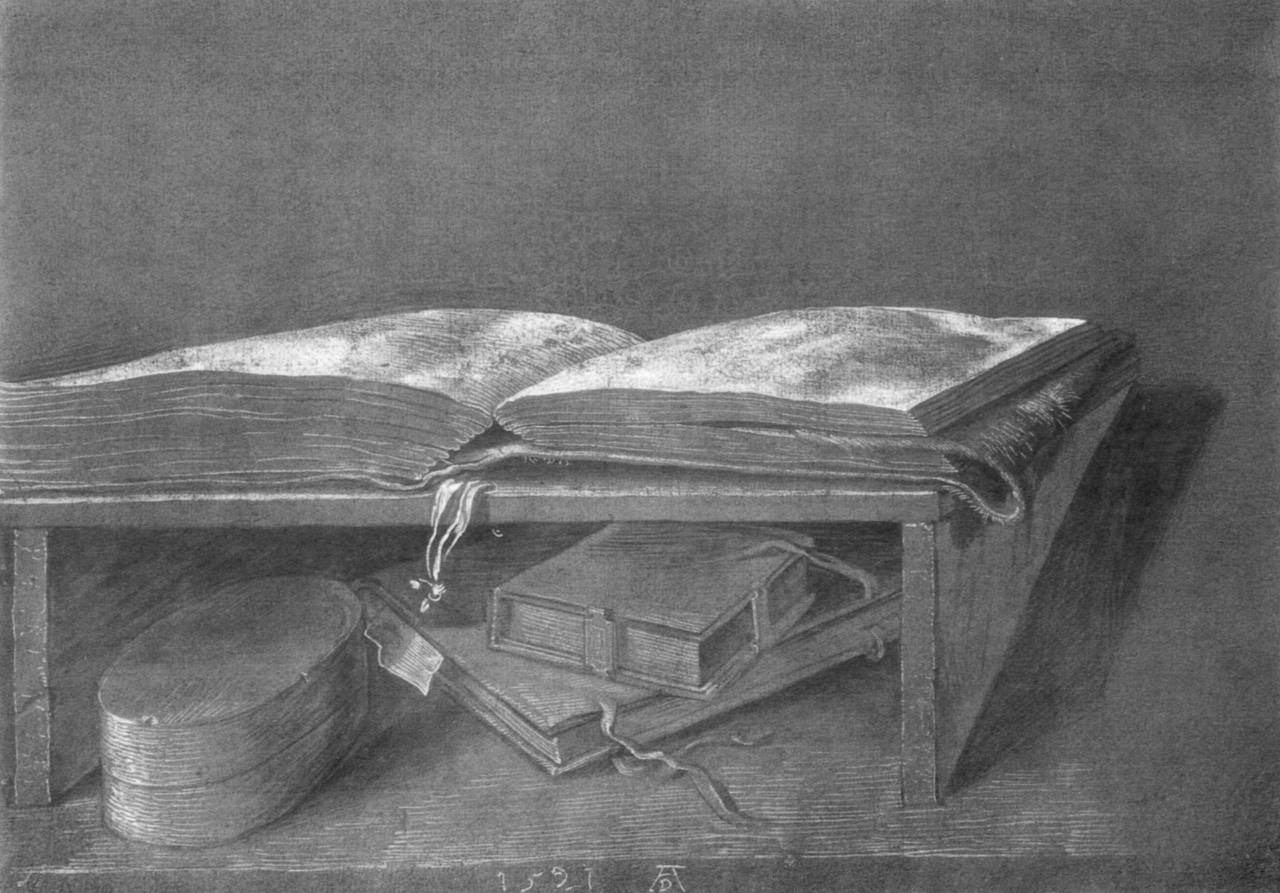

In [19]:
display(img)

In [20]:
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])
img_t = transform(img)
img_t.shape

torch.Size([3, 64, 64])

<Axes: >

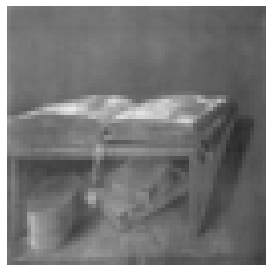

In [21]:
show_image(img_t)

Oddly enough, this looks ok too.

### Normalise/standardise images

In [22]:
train_tensor_list = []

transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])

for img_path, _ in train_ds:
    img = Image.open(img_path)
    img_t = transform(img)
    if img_t.shape != torch.Size([3, 64, 64]):
        os.remove(img_path)
        print(f"Removed {img_path}")
        continue
    train_tensor_list.append(img_t)

stacked_train_tensors = torch.stack(train_tensor_list, dim=0)
x_mean = torch.mean(stacked_train_tensors, dim=(0,2,3))
x_std = torch.std(stacked_train_tensors, dim=(0,2,3))

x_mean, x_std

(tensor([0.60313, 0.56858, 0.53134]), tensor([0.23981, 0.24546, 0.26040]))

In [23]:
for img_path, _ in val_ds:
    img = Image.open(img_path)
    img_t = transform(img)
    if img_t.shape != torch.Size([3, 64, 64]):
        os.remove(img_path)
        print(f"Removed {img_path}")
        continue

In [24]:
img_t - x_mean[:,None,None]

tensor([[[ 0.08707,  0.06354,  0.06354,  ...,  0.05570,  0.05962,  0.09883],
         [ 0.07138,  0.06354,  0.07530,  ...,  0.08315,  0.08707,  0.08707],
         [ 0.06746,  0.08315,  0.07923,  ...,  0.11060,  0.06354,  0.06746],
         ...,
         [ 0.13805,  0.12628,  0.08707,  ...,  0.19295,  0.18511,  0.18511],
         [ 0.14981,  0.17727,  0.15374,  ...,  0.20079,  0.21256,  0.22825],
         [ 0.16550,  0.19687,  0.19295,  ...,  0.21648,  0.22432,  0.23609]],

        [[-0.02741, -0.08231, -0.08231,  ..., -0.12937, -0.11368, -0.07839],
         [-0.05878, -0.08623, -0.09015,  ..., -0.10584, -0.09015, -0.09407],
         [-0.07054, -0.07447, -0.09015,  ..., -0.07447, -0.12937, -0.12937],
         ...,
         [-0.00388, -0.03525, -0.10976,  ..., -0.01564, -0.01172, -0.00388],
         [ 0.02749,  0.05495, -0.00780,  ...,  0.01181,  0.03534,  0.05887],
         [ 0.05887,  0.09024,  0.06279,  ...,  0.03926,  0.05887,  0.07847]],

        [[-0.18232, -0.23330, -0.24114,  ...

In [25]:
def tfmx(x):
    img = Image.open(x)
    transform = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        # transforms.Normalize(x_mean[:,None,None], x_std[:,None,None]),
    ])
    img_t = transform(img)
    return img_t


In [26]:
str2id = {
    "Albrecht_Du╠êrer": 0,
    "Albrecht_Dürer": 1,
    "Alfred_Sisley": 2,
    "Amedeo_Modigliani": 3,
    "Andrei_Rublev": 4,
    "Andy_Warhol": 5,
}

In [27]:
id2str = {v:k for k,v in str2id.items()}

In [28]:
def tfmy(y): return tensor(str2id[y])

In [29]:
class TfmDS:
    def __init__(self, ds, tfmx=fc.noop, tfmy=fc.noop): self.ds,self.tfmx,self.tfmy = ds,tfmx,tfmy
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        x,y = self.ds[i]
        return self.tfmx(x),self.tfmy(y)

In [30]:
tfm_tds = TfmDS(train_ds, tfmx, tfmy)
tfm_vds = TfmDS(val_ds, tfmx, tfmy)

In [31]:
x0, y0 = tfm_tds[0]
x0, y0

(tensor([[[0.52549, 0.48627, 0.47451,  ..., 0.34118, 0.33725, 0.34510],
          [0.49412, 0.45882, 0.44706,  ..., 0.33725, 0.32549, 0.33725],
          [0.48235, 0.44706, 0.43922,  ..., 0.33725, 0.33333, 0.36471],
          ...,
          [0.45098, 0.40784, 0.40784,  ..., 0.28235, 0.25882, 0.26275],
          [0.43922, 0.44706, 0.47059,  ..., 0.25490, 0.23529, 0.25882],
          [0.43137, 0.41176, 0.39216,  ..., 0.27059, 0.25490, 0.26667]],
 
         [[0.52549, 0.48627, 0.47451,  ..., 0.34118, 0.33725, 0.34510],
          [0.49412, 0.45882, 0.44706,  ..., 0.33725, 0.32549, 0.33725],
          [0.48235, 0.44706, 0.43922,  ..., 0.33725, 0.33333, 0.36471],
          ...,
          [0.45098, 0.40784, 0.40784,  ..., 0.28235, 0.25882, 0.26275],
          [0.43922, 0.44706, 0.47059,  ..., 0.25490, 0.23529, 0.25882],
          [0.43137, 0.41176, 0.39216,  ..., 0.27059, 0.25490, 0.26667]],
 
         [[0.52549, 0.48627, 0.47451,  ..., 0.34118, 0.33725, 0.34510],
          [0.49412, 0.45882,

In [32]:
x1, y1 = tfm_tds[1]
x1, y1

(tensor([[[0.99216, 0.98039, 0.97255,  ..., 0.88235, 0.90196, 0.98824],
          [0.98431, 0.81961, 0.83529,  ..., 0.47843, 0.42353, 0.87843],
          [0.98039, 0.86275, 0.86275,  ..., 0.43922, 0.34118, 0.77647],
          ...,
          [0.86667, 0.71373, 0.64706,  ..., 0.57647, 0.77255, 0.96863],
          [0.85490, 0.66275, 0.68627,  ..., 0.55686, 0.74510, 0.96471],
          [0.95686, 0.91765, 0.91765,  ..., 0.76863, 0.82745, 0.97255]],
 
         [[0.99216, 0.98039, 0.97255,  ..., 0.88235, 0.90196, 0.98824],
          [0.98431, 0.81961, 0.83529,  ..., 0.47843, 0.42353, 0.87843],
          [0.98039, 0.86275, 0.86275,  ..., 0.43922, 0.34118, 0.77647],
          ...,
          [0.86667, 0.71373, 0.64706,  ..., 0.57647, 0.77255, 0.96863],
          [0.85490, 0.66275, 0.68627,  ..., 0.55686, 0.74510, 0.96471],
          [0.95686, 0.91765, 0.91765,  ..., 0.76863, 0.82745, 0.97255]],
 
         [[0.99216, 0.98039, 0.97255,  ..., 0.88235, 0.90196, 0.98824],
          [0.98431, 0.81961,

In [33]:
train_ds[0]

('data/tiny-best-artwork/Albrecht_Du╠êrer/train/Albrecht_Du╠êrer_14.jpg',
 'Albrecht_Du╠êrer')

In [34]:
train_ds[1]

('data/tiny-best-artwork/Albrecht_Du╠êrer/train/Albrecht_Du╠êrer_253.jpg',
 'Albrecht_Du╠êrer')

<Axes: >

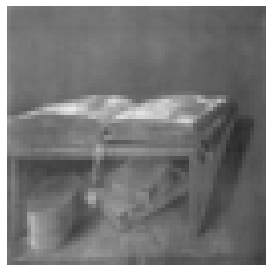

In [35]:
show_image(x0)

In [36]:
torch.max(x0)

tensor(0.90980)

In [37]:
torch.min(x0)

tensor(0.16471)

Because standardisation skews the min/max pixel values to be (imo) not within the same range (-2 to 1), I've decided to put aside standardisation first and try it out later if necessary.

### DataLoaders

In [38]:
train_dl = DataLoader(tfm_tds, batch_size=bs, shuffle=True, num_workers=0)
valid_dl = DataLoader(tfm_vds, batch_size=bs, shuffle=False, num_workers=0)

In [39]:
xb, yb = b = next(iter(train_dl))

In [40]:
len(xb)

128

In [41]:
titles = [id2str[int(o)] for o in yb]
', '.join(titles[:16])

'Andy_Warhol, Albrecht_Du╠êrer, Andrei_Rublev, Amedeo_Modigliani, Andrei_Rublev, Albrecht_Dürer, Amedeo_Modigliani, Albrecht_Du╠êrer, Alfred_Sisley, Amedeo_Modigliani, Alfred_Sisley, Alfred_Sisley, Albrecht_Dürer, Alfred_Sisley, Andrei_Rublev, Albrecht_Du╠êrer'

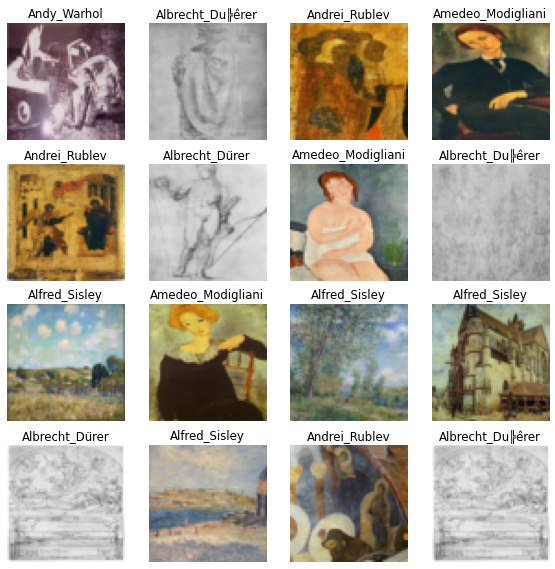

In [42]:
show_images(xb[:16], titles=titles[:16], imsize=2.5)

In [43]:
dls = DataLoaders(*get_dls(tfm_tds, tfm_vds, bs=bs, num_workers=1))

## Basic Model

In [44]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

In [66]:
nfs = (8, 16, 32, 64, 128)

In [67]:
def get_dropmodel(act=act_gr, nfs=nfs, norm=nn.BatchNorm2d, drop=0.1):
    layers = [nn.Conv2d(3, nfs[0], 5, padding=2)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
               for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(drop)]
    #layers += [nn.Linear(nfs[-1], 6, bias=False), nn.BatchNorm1d(6)]
    layers += [nn.Linear(nfs[-1], 64, bias=True), 
               nn.Linear(64, 16, bias=True),
               nn.Linear(16, 6, bias=False),
               nn.BatchNorm1d(6)]
    return nn.Sequential(*layers).apply(iw).to(def_device)

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


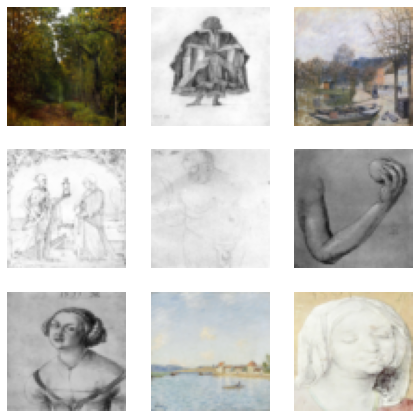

In [68]:
learn = TrainLearner(get_dropmodel(), dls, F.cross_entropy, cbs=[SingleBatchCB(), DeviceCB()])
learn.fit(1)
xb,yb = learn.batch
show_images(xb.cpu()[:9], imsize=2.5)

In [69]:
learn.summary()

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Tot params: 316332; MFLOPS: 17.1


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Conv2d|(128, 3, 64, 64)|(128, 8, 64, 64)|608|2.5|
|ResBlock|(128, 8, 64, 64)|(128, 16, 32, 32)|3696|3.7|
|ResBlock|(128, 16, 32, 32)|(128, 32, 16, 16)|14560|3.7|
|ResBlock|(128, 32, 16, 16)|(128, 64, 8, 8)|57792|3.7|
|ResBlock|(128, 64, 8, 8)|(128, 128, 4, 4)|230272|3.7|
|AdaptiveAvgPool2d|(128, 128, 4, 4)|(128, 128, 1, 1)|0|0.0|
|Flatten|(128, 128, 1, 1)|(128, 128)|0|0.0|
|Dropout|(128, 128)|(128, 128)|0|0.0|
|Linear|(128, 128)|(128, 64)|8256|0.0|
|Linear|(128, 64)|(128, 16)|1040|0.0|
|Linear|(128, 16)|(128, 6)|96|0.0|
|BatchNorm1d|(128, 6)|(128, 6)|12|0.0|


In [70]:
opt_func = partial(optim.AdamW, eps=1e-5)

In [71]:
lr_cbs = [DeviceCB(), ProgressCB()]

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started 

KeyboardInterrupt: 

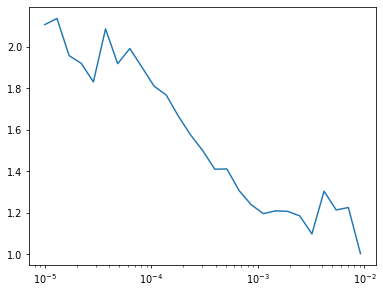

In [72]:
learn = TrainLearner(get_dropmodel(), dls, F.cross_entropy, cbs=lr_cbs, opt_func=opt_func)
learn.lr_find()

In [73]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]

In [74]:
epochs=25
lr=1e-3
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
learn = TrainLearner(get_dropmodel(), dls, F.cross_entropy, lr=lr, cbs=cbs, opt_func=opt_func)

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


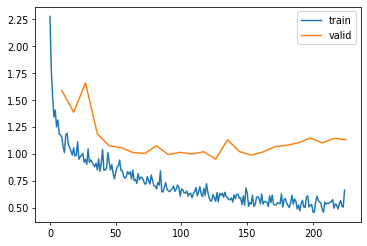

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started 

In [75]:
learn.fit(epochs)

We see that validation loss stops dropping around epoch 13. Let's try a deeper model.

## Deeper model

In [76]:
def res_blocks(n_bk, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
    return nn.Sequential(*[
        ResBlock(ni if i==0 else nf, nf, stride=stride if i==n_bk-1 else 1, ks=ks, act=act, norm=norm)
        for i in range(n_bk)])

In [77]:
nbks = (3,2,2,1,1)

In [97]:
def get_dropmodel(act=act_gr, nfs=nfs, nbks=nbks, norm=nn.BatchNorm2d, drop=0.2):
    layers = [ResBlock(3, nfs[0], ks=5, stride=1, act=act, norm=norm)]
    layers += [res_blocks(nbks[i], nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
               for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(drop)]
    #layers += [nn.Linear(nfs[-1], 200, bias=False), nn.BatchNorm1d(200)]
    layers += [nn.Linear(nfs[-1], 64, bias=True),
               nn.Linear(64, 32, bias=True),
               nn.Linear(32, 6, bias=False),
               nn.BatchNorm1d(6)]
    return nn.Sequential(*layers).apply(iw).to(def_device)

In [88]:
learn = TrainLearner(get_dropmodel(), dls, F.cross_entropy, cbs=[SingleBatchCB(), DeviceCB()])

In [89]:
learn.summary()

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Tot params: 421284; MFLOPS: 42.7


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|ResBlock|(128, 3, 64, 64)|(128, 8, 64, 64)|2280|9.1|
|Sequential|(128, 8, 64, 64)|(128, 16, 32, 32)|13104|13.1|
|Sequential|(128, 16, 32, 32)|(128, 32, 16, 16)|33184|8.4|
|Sequential|(128, 32, 16, 16)|(128, 64, 8, 8)|131904|8.4|
|Sequential|(128, 64, 8, 8)|(128, 128, 4, 4)|230272|3.7|
|AdaptiveAvgPool2d|(128, 128, 4, 4)|(128, 128, 1, 1)|0|0.0|
|Flatten|(128, 128, 1, 1)|(128, 128)|0|0.0|
|Dropout|(128, 128)|(128, 128)|0|0.0|
|Linear|(128, 128)|(128, 64)|8256|0.0|
|Linear|(128, 64)|(128, 32)|2080|0.0|
|Linear|(128, 32)|(128, 6)|192|0.0|
|BatchNorm1d|(128, 6)|(128, 6)|12|0.0|


In [90]:
opt_func = partial(optim.AdamW, eps=1e-5)

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started 

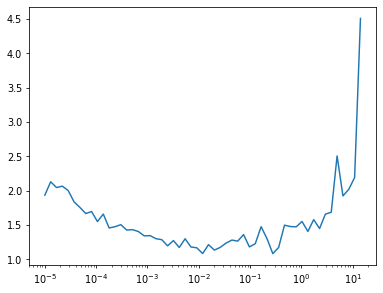

In [91]:
learn = TrainLearner(get_dropmodel(), dls, F.cross_entropy, cbs=lr_cbs, opt_func=opt_func)
learn.lr_find()

In [98]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]

epochs = 20
lr = 5e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(get_dropmodel(), dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


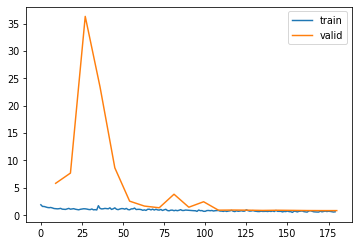

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started 

In [99]:
learn.fit(epochs)

We see a slight improvement in evaluation score. Let's try to set a lower learning rate and see if we can reduce the initial spikes in loss.

In [104]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]

epochs = 20
lr = 5e-3
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(get_dropmodel(), dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


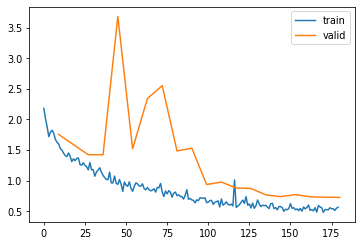

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started 

In [105]:
learn.fit(epochs)

In [106]:
torch.save(learn.model, 'models/best-artwork-20.pkl')

## Data processing (content images)

In [8]:
content_path = path_data/'voc'

In [11]:
content_data_prepped = True

if not content_data_prepped:
    files = list(glob(str(content_path/'*.jpg')))
    train_files, test_files = train_test_split(files, test_size=0.2)

    # Create `train` and `test` folders
    train_folder = content_path/'train'
    test_folder = content_path/'test'
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Move files to `train` folder
    for train_file in train_files:
        shutil.move(train_file, train_folder / os.path.basename(train_file))

    # Move files to `test` folder
    for test_file in test_files:
        shutil.move(test_file, test_folder / os.path.basename(test_file))


In [12]:
class ContentDS:
    def __init__(self, path, train_or_test):
        self.path = Path(path)
        self.files = glob(str(self.path/f"{train_or_test}/*.jpg"), recursive=True)

    def __len__(self): return len(self.files)

    def __getitem__(self, i):
        return self.files[i]

In [13]:
train_content_ds = ContentDS(content_path, "train")
len(train_content_ds)

4008

In [14]:
train_content_ds[0]

'data/voc/train/003301.jpg'

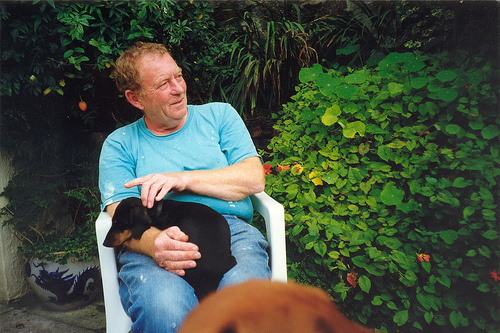

In [15]:
img = Image.open(train_content_ds[0])
display(img)

In [16]:
val_content_ds = ContentDS(content_path, "test")
len(val_content_ds)

1003

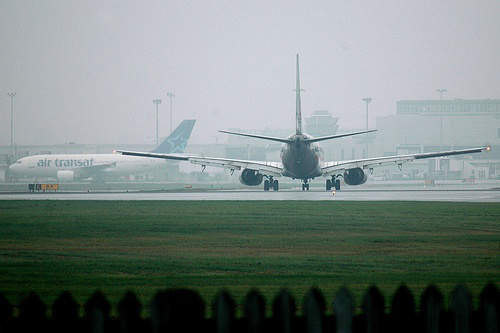

In [17]:
img = Image.open(val_content_ds[0])
display(img)

In [18]:
def content_tfmx(x, erase=True):
    img = Image.open(x)
    transform = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        # transforms.Normalize(x_mean[:,None,None], x_std[:,None,None]),
    ])
    img_t = transform(img)[None]
    if erase: img_t = rand_erase(img_t)
    return img_t[0]


In [19]:
class TfmContentDS:
    def __init__(self, ds, tfmx=fc.noop, tfmy=fc.noop):
        self.ds, self.tfmx, self.tfmy = ds, tfmx, tfmy
    
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, i):
        item = self.ds[i]
        return self.tfmx(item), self.tfmy(item)

In [21]:
bs=128

In [22]:
tfm_ctds = TfmContentDS(train_content_ds, content_tfmx, partial(content_tfmx, erase=False))
tfm_cvds = TfmContentDS(val_content_ds, content_tfmx, partial(content_tfmx, erase=False))

dls = DataLoaders(*get_dls(tfm_ctds, tfm_cvds, bs=bs, num_workers=1))

In [23]:
xb, yb = next(iter(dls.train))

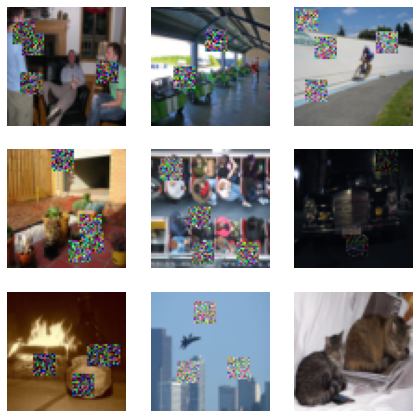

In [24]:
show_images(xb[:9], imsize=2.5)

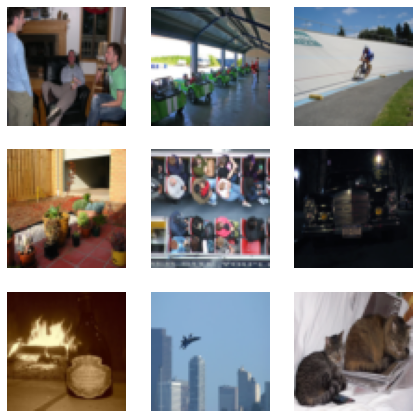

In [25]:
show_images(yb[:9], imsize=2.5)

## U-net
We are using a U-net to reproduce the content image it is given.

In [26]:
def up_block(ni, nf, ks=3, act=act_gr, norm=None):
    return nn.Sequential(nn.UpsamplingNearest2d(scale_factor=2),
                         ResBlock(ni, nf, ks=ks, act=act, norm=norm))

In [27]:
class TinyUnet(nn.Module):
    def __init__(self, act=act_gr, nfs=(32,64,128,256), norm=nn.BatchNorm2d):
        super().__init__()
        self.start = ResBlock(3, nfs[0], stride=1, act=act, norm=norm)
        self.dn = nn.ModuleList([ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
                                 for i in range(len(nfs)-1)])
        self.up = nn.ModuleList([up_block(nfs[i], nfs[i-1], act=act, norm=norm)
                                 for i in range(len(nfs)-1,0,-1)])
        self.up += [ResBlock(nfs[0], 3, act=act, norm=norm)]
        self.end = ResBlock(3, 3, act=nn.Identity, norm=norm)

    def forward(self, x):
        layers = []
        layers.append(x)
        x = self.start(x)
        for l in self.dn:
            layers.append(x)
            x = l(x)
        n = len(layers)
        for i,l in enumerate(self.up):
            if i!=0: x += layers[n-i]
            x = l(x)
        return self.end(x+layers[0])

In [28]:
def zero_wgts(l):
    with torch.no_grad():
        l.weight.zero_()
        l.bias.zero_()

In [29]:
model = TinyUnet()

In [30]:
model.up[-1]

ResBlock(
  (convs): Sequential(
    (0): Sequential(
      (0): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GeneralRelu()
    )
    (1): Sequential(
      (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (idconv): Sequential(
    (0): Conv2d(32, 3, kernel_size=(1, 1), stride=(1, 1))
  )
  (act): GeneralRelu()
)

In [31]:
last_res = model.up[-1]
zero_wgts(last_res.convs[-1][-1])
zero_wgts(last_res.idconv[0])
zero_wgts(model.end.convs[-1][-1])

First, let's start training a U-net (without the style transfer) to check if it can generate similar images as its inputs.

In [34]:
epochs = 20
lr = 1e-3
tmax = epochs * len(dls.train)
metrics = MetricsCB()
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
opt_func = partial(optim.AdamW, eps=1e-5)
learn = TrainLearner(model, dls, F.mse_loss, lr=lr, cbs=cbs,opt_func=opt_func)

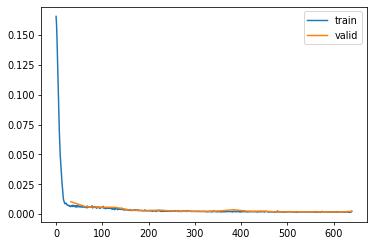

In [35]:
learn.fit(epochs)

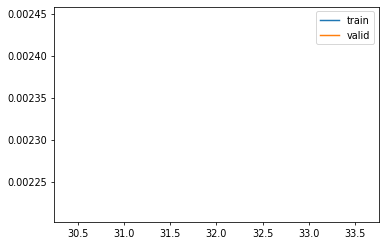

In [36]:
p,t,inp = learn.capture_preds(inps=True)

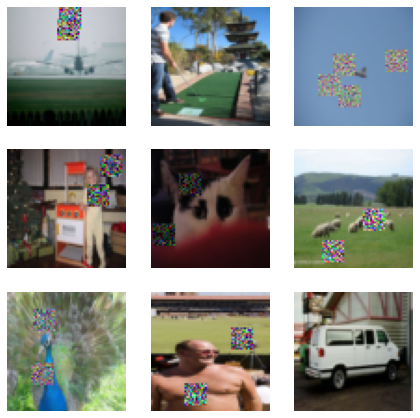

In [37]:
show_images(inp[:9], imsize=2.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


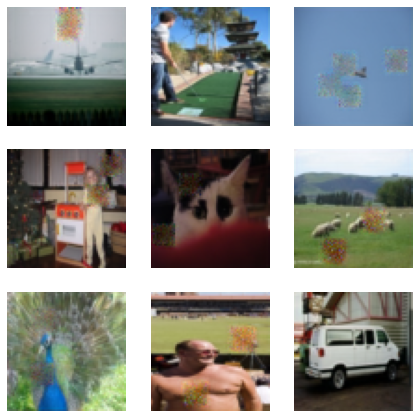

In [38]:
show_images(p[:9], imsize=2.5)

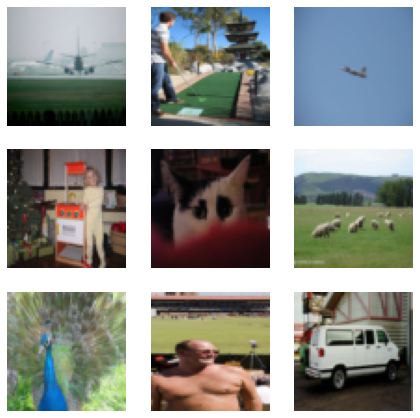

In [41]:
show_images(t[:9], imsize=2.5)

The model still struggles a bit with random erasing, but otherwise it's doing a pretty good job.

## Style loss

In [42]:
cmodel = torch.load('models/best-artwork-20.pkl').to(def_device)

In [44]:
xb, yb = next(iter(dls.valid))
with torch.no_grad():
    preds = to_cpu(cmodel(yb.to(def_device)))
preds.shape

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


torch.Size([256, 6])

In [45]:
yb.shape

torch.Size([256, 3, 64, 64])

In [46]:
cmodel

Sequential(
  (0): ResBlock(
    (convs): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GeneralRelu()
      )
      (1): Sequential(
        (0): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (idconv): Sequential(
      (0): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1))
    )
    (act): GeneralRelu()
  )
  (1): Sequential(
    (0): ResBlock(
      (convs): Sequential(
        (0): Sequential(
          (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): GeneralRelu()
        )
        (1): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1),

In [53]:
cmodel[-1]

BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

We want to delete the layers that do not contain information about the features of the images and only keep the ResBlocks.

In [54]:
for i in range(7):
    del(cmodel[-1])

In [55]:
cmodel

Sequential(
  (0): ResBlock(
    (convs): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GeneralRelu()
      )
      (1): Sequential(
        (0): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (idconv): Sequential(
      (0): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1))
    )
    (act): GeneralRelu()
  )
  (1): Sequential(
    (0): ResBlock(
      (convs): Sequential(
        (0): Sequential(
          (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): GeneralRelu()
        )
        (1): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1),

In [56]:
with torch.no_grad():
    preds = to_cpu(cmodel(yb.to(def_device)))

preds.shape

torch.Size([256, 128, 4, 4])

In [62]:
def gram_matrix(input):
    batch_size, num_feature_maps, h_feature_map, w_feature_map = input.shape
    features = input.view(batch_size * num_feature_maps, h_feature_map * w_feature_map)
    G = torch.mm(features, features.t())
    return G.div(batch_size * num_feature_maps * h_feature_map * w_feature_map)

In [64]:
gram_matrix(preds).shape

torch.Size([32768, 32768])

I have to update my `dls` to contain 2 sets of images (content and style).

## Data processing: Style and content images

In [66]:
style_path = path_data/'tiny-best-artwork'
content_path = path_data/'voc'

In [69]:
class StyleAndContentDS:
    def __init__(self, style_path, content_path, train_or_test):
        self.style_path = Path(style_path)
        self.content_path = Path(content_path)
        self.style_files = glob(str(self.style_path/f"*/{train_or_test}/*.jpg"), recursive=True)
        self.content_files = glob(str(self.content_path/f"{train_or_test}/*.jpg"), recursive=True)

    def __len__(self): return len(self.style_files)

    def __getitem__(self, i):
        return self.style_files[i], self.content_files[i]

In [73]:
snc_tds = StyleAndContentDS(style_path, content_path, "train")
snc_vds = StyleAndContentDS(style_path, content_path, "test")

In [74]:
snc_tds[0], snc_vds[0]

(('data/tiny-best-artwork/Albrecht_Du╠êrer/train/Albrecht_Du╠êrer_14.jpg',
  'data/voc/train/003301.jpg'),
 ('data/tiny-best-artwork/Albrecht_Du╠êrer/test/Albrecht_Du╠êrer_247.jpg',
  'data/voc/test/005016.jpg'))

In [83]:
class TfmStyleAndContentDS:
    def __init__(self, ds, tfmx=fc.noop, tfmy=fc.noop):
        self.ds, self.tfmx, self.tfmy = ds, tfmx, tfmy
    
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, i):
        style_item, content_item = self.ds[i]
        return self.tfmx(content_item), self.tfmy(style_item), self.tfmy(content_item)

In [84]:
def def_tfmx(x):
    img = Image.open(x)
    transform = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        # transforms.Normalize(x_mean[:,None,None], x_std[:,None,None]),
    ])
    img_t = transform(img)
    return img_t

In [85]:
tfm_snc_tds = TfmStyleAndContentDS(snc_tds, tfmx=content_tfmx, tfmy=def_tfmx)
tfm_snc_vds = TfmStyleAndContentDS(snc_vds, tfmx=content_tfmx, tfmy=def_tfmx)

In [86]:
dls = DataLoaders(*get_dls(tfm_snc_tds, tfm_snc_vds, bs=bs, num_workers=1))

In [87]:
xc, xs, yc = next(iter(dls.train))

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


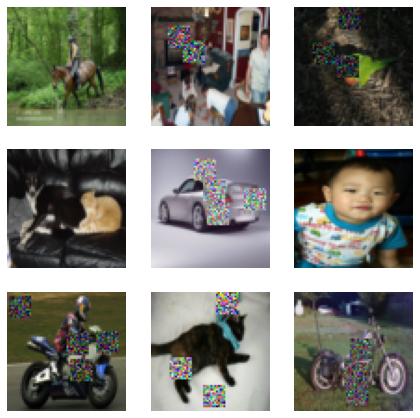

In [88]:
show_images(xc[:9], imsize=2.5)

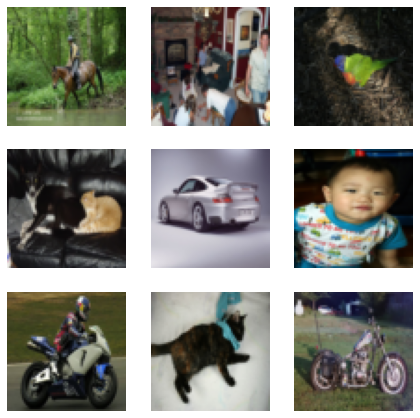

In [90]:
show_images(yc[:9], imsize=2.5)

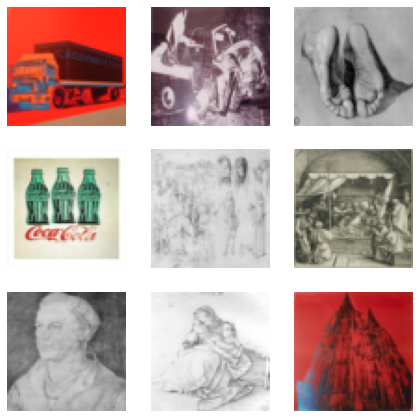

In [89]:
show_images(xs[:9], imsize=2.5)

We will continue to use our `cmodel` from above to calculate our Gram matrix.

In [91]:
def get_unet():
    model = TinyUnet()
    last_res = model.up[-1]
    zero_wgts(last_res.convs[-1][-1])
    zero_wgts(last_res.idconv[0])
    zero_wgts(model.end.convs[-1][-1])
    return model

In [138]:
def comb_loss(content_pred, style, content_tgt):
    style_scale_factor = 1e6
    # calculate gram matrices and MSE loss
    with torch.no_grad():
        style_gram = gram_matrix(style)
        content_gram = gram_matrix(content_pred)
        style_loss = F.mse_loss(style_gram, content_gram) * style_scale_factor
    content_loss = F.mse_loss(content_pred, content_tgt)
    print(f"Content loss: {content_loss:.4f}, Style loss: {style_loss:.8f}")
    return content_loss + style_loss

In [142]:
epochs = 25
lr = 1e-4
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
metrics = MetricsCB()
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
xtra = [BatchSchedCB(sched)]

In [143]:
class StyleTransferLearner(TrainLearner):
    def get_loss(self):
        self.loss = self.loss_func(self.preds, self.batch[1], self.batch[2])

In [144]:
learn = StyleTransferLearner(get_unet(), dls, comb_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.1675, Style loss: 0.83102363
Content loss: 0.1664, Style loss: 0.86169487
Content loss: 0.1673, Style loss: 0.79421884
Content loss: 0.1669, Style loss: 0.92058408
Content loss: 0.1668, Style loss: 0.70825332
Content loss: 0.1652, Style loss: 0.78780735
Content loss: 0.1673, Style loss: 1.00886345
Content loss: 0.1667, Style loss: 0.90406835
Content loss: 0.1651, Style loss: 2.43288207


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.1659, Style loss: 0.19309998
Content loss: 0.1652, Style loss: 46.58150101


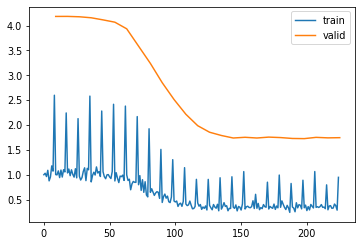

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.1651, Style loss: 0.83632755
Content loss: 0.1672, Style loss: 0.82810247
Content loss: 0.1649, Style loss: 0.91075152
Content loss: 0.1665, Style loss: 0.77436715
Content loss: 0.1676, Style loss: 0.92472535
Content loss: 0.1657, Style loss: 0.78627098
Content loss: 0.1648, Style loss: 0.93439078
Content loss: 0.1651, Style loss: 0.88974291
Content loss: 0.1663, Style loss: 2.07519960


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.1654, Style loss: 0.19300997
Content loss: 0.1649, Style loss: 46.59727478


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.1643, Style loss: 0.87007070
Content loss: 0.1648, Style loss: 0.94799644
Content loss: 0.1650, Style loss: 0.81397969
Content loss: 0.1641, Style loss: 0.93324786
Content loss: 0.1649, Style loss: 0.84032065
Content loss: 0.1652, Style loss: 0.78500772
Content loss: 0.1643, Style loss: 0.95467806
Content loss: 0.1635, Style loss: 0.77177376
Content loss: 0.1648, Style loss: 1.96226227


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.1632, Style loss: 0.19283772
Content loss: 0.1612, Style loss: 46.53596497


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.1632, Style loss: 0.80604643
Content loss: 0.1631, Style loss: 0.72894830
Content loss: 0.1618, Style loss: 0.77871847
Content loss: 0.1626, Style loss: 0.90346396
Content loss: 0.1629, Style loss: 0.97460419
Content loss: 0.1597, Style loss: 0.72012889
Content loss: 0.1609, Style loss: 0.96567225
Content loss: 0.1594, Style loss: 0.93846977
Content loss: 0.1590, Style loss: 2.42126703


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.1540, Style loss: 0.19214764
Content loss: 0.1549, Style loss: 46.40777206


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.1592, Style loss: 0.69509733
Content loss: 0.1563, Style loss: 0.82599860
Content loss: 0.1561, Style loss: 0.89265293
Content loss: 0.1565, Style loss: 0.83606070
Content loss: 0.1546, Style loss: 1.00078773
Content loss: 0.1525, Style loss: 0.88062292
Content loss: 0.1517, Style loss: 0.91132045
Content loss: 0.1517, Style loss: 0.81111318
Content loss: 0.1484, Style loss: 2.13155079


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.1410, Style loss: 0.19043599
Content loss: 0.1404, Style loss: 46.07173538


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.1482, Style loss: 0.91001350
Content loss: 0.1463, Style loss: 0.81283998
Content loss: 0.1433, Style loss: 0.77522117
Content loss: 0.1431, Style loss: 0.85376918
Content loss: 0.1400, Style loss: 0.86118925
Content loss: 0.1378, Style loss: 0.81601137
Content loss: 0.1349, Style loss: 0.78731620
Content loss: 0.1339, Style loss: 0.92868584
Content loss: 0.1317, Style loss: 2.28401065


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.1307, Style loss: 0.18844266
Content loss: 0.1285, Style loss: 45.65637207


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.1277, Style loss: 0.74546415
Content loss: 0.1248, Style loss: 0.91448337
Content loss: 0.1211, Style loss: 0.80684030
Content loss: 0.1188, Style loss: 0.72171068
Content loss: 0.1165, Style loss: 0.85423303
Content loss: 0.1115, Style loss: 0.84835422
Content loss: 0.1097, Style loss: 0.88110596
Content loss: 0.1040, Style loss: 0.78003579
Content loss: 0.1018, Style loss: 2.27770805


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.1104, Style loss: 0.18276301
Content loss: 0.1077, Style loss: 44.35076904


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0972, Style loss: 0.89801145
Content loss: 0.0942, Style loss: 0.78867179
Content loss: 0.0910, Style loss: 0.81705570
Content loss: 0.0879, Style loss: 0.60797507
Content loss: 0.0845, Style loss: 0.72894681
Content loss: 0.0819, Style loss: 0.78125060
Content loss: 0.0786, Style loss: 0.76786596
Content loss: 0.0745, Style loss: 0.77028131
Content loss: 0.0714, Style loss: 2.09683990


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0757, Style loss: 0.16703512
Content loss: 0.0664, Style loss: 40.72890854


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0687, Style loss: 0.72879523
Content loss: 0.0653, Style loss: 0.91499335
Content loss: 0.0615, Style loss: 0.62124735
Content loss: 0.0606, Style loss: 0.83763462
Content loss: 0.0542, Style loss: 0.58987510
Content loss: 0.0543, Style loss: 0.80343258
Content loss: 0.0498, Style loss: 0.54205501
Content loss: 0.0480, Style loss: 0.50495446
Content loss: 0.0444, Style loss: 1.87885571


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0509, Style loss: 0.14836906
Content loss: 0.0494, Style loss: 37.01384735


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0450, Style loss: 0.59985036
Content loss: 0.0407, Style loss: 0.67568427
Content loss: 0.0378, Style loss: 0.60859030
Content loss: 0.0358, Style loss: 0.54684591
Content loss: 0.0344, Style loss: 0.59698009
Content loss: 0.0338, Style loss: 0.62342191
Content loss: 0.0292, Style loss: 0.61634970
Content loss: 0.0277, Style loss: 0.49492854
Content loss: 0.0256, Style loss: 1.48218203


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0325, Style loss: 0.12936807
Content loss: 0.0287, Style loss: 32.74405670


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0243, Style loss: 0.41634849
Content loss: 0.0236, Style loss: 0.53416938
Content loss: 0.0210, Style loss: 0.58817339
Content loss: 0.0198, Style loss: 0.50758916
Content loss: 0.0194, Style loss: 0.54884309
Content loss: 0.0174, Style loss: 0.43714702
Content loss: 0.0156, Style loss: 0.42239428
Content loss: 0.0150, Style loss: 0.53571874
Content loss: 0.0149, Style loss: 1.28675592


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0197, Style loss: 0.11090635
Content loss: 0.0175, Style loss: 28.99392891


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0142, Style loss: 0.45523283
Content loss: 0.0117, Style loss: 0.43878472
Content loss: 0.0114, Style loss: 0.45808399
Content loss: 0.0112, Style loss: 0.34957013
Content loss: 0.0098, Style loss: 0.40199661
Content loss: 0.0087, Style loss: 0.41720697
Content loss: 0.0092, Style loss: 0.35331041
Content loss: 0.0081, Style loss: 0.45283851
Content loss: 0.0084, Style loss: 1.13215947


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0120, Style loss: 0.09673215
Content loss: 0.0128, Style loss: 25.63804436


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0089, Style loss: 0.39956245
Content loss: 0.0079, Style loss: 0.36941698
Content loss: 0.0074, Style loss: 0.38477200
Content loss: 0.0087, Style loss: 0.45974568
Content loss: 0.0082, Style loss: 0.37717122
Content loss: 0.0072, Style loss: 0.30604374
Content loss: 0.0073, Style loss: 0.31145114
Content loss: 0.0063, Style loss: 0.35309833
Content loss: 0.0071, Style loss: 0.89862132


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0081, Style loss: 0.08587640
Content loss: 0.0071, Style loss: 23.02203560


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0068, Style loss: 0.42283878
Content loss: 0.0064, Style loss: 0.35866323
Content loss: 0.0071, Style loss: 0.39149857
Content loss: 0.0068, Style loss: 0.29498535
Content loss: 0.0063, Style loss: 0.34376132
Content loss: 0.0071, Style loss: 0.31501395
Content loss: 0.0072, Style loss: 0.36327285
Content loss: 0.0068, Style loss: 0.28219625
Content loss: 0.0067, Style loss: 0.89803094


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0068, Style loss: 0.07955270
Content loss: 0.0092, Style loss: 21.51368141


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0064, Style loss: 0.37600252
Content loss: 0.0063, Style loss: 0.32723761
Content loss: 0.0063, Style loss: 0.28728932
Content loss: 0.0071, Style loss: 0.39214930
Content loss: 0.0060, Style loss: 0.34348121
Content loss: 0.0076, Style loss: 0.31660509
Content loss: 0.0065, Style loss: 0.39687127
Content loss: 0.0076, Style loss: 0.26518404
Content loss: 0.0071, Style loss: 0.93063927


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0059, Style loss: 0.07721383
Content loss: 0.0080, Style loss: 20.75432014


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0060, Style loss: 0.30073404
Content loss: 0.0067, Style loss: 0.35402709
Content loss: 0.0063, Style loss: 0.43027240
Content loss: 0.0064, Style loss: 0.35393238
Content loss: 0.0062, Style loss: 0.36904123
Content loss: 0.0067, Style loss: 0.26651675
Content loss: 0.0070, Style loss: 0.31549537
Content loss: 0.0063, Style loss: 0.31321204
Content loss: 0.0072, Style loss: 0.95024848


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0066, Style loss: 0.07624942
Content loss: 0.0067, Style loss: 20.14547348


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0064, Style loss: 0.33974701
Content loss: 0.0062, Style loss: 0.31584615
Content loss: 0.0063, Style loss: 0.38477758
Content loss: 0.0070, Style loss: 0.26385486
Content loss: 0.0062, Style loss: 0.35373199
Content loss: 0.0067, Style loss: 0.33939856
Content loss: 0.0051, Style loss: 0.28327444
Content loss: 0.0069, Style loss: 0.40425962
Content loss: 0.0071, Style loss: 1.05460036


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0059, Style loss: 0.07582608
Content loss: 0.0058, Style loss: 20.33238792


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0071, Style loss: 0.30171180
Content loss: 0.0070, Style loss: 0.34536338
Content loss: 0.0068, Style loss: 0.35845923
Content loss: 0.0064, Style loss: 0.33400258
Content loss: 0.0067, Style loss: 0.32823542
Content loss: 0.0063, Style loss: 0.35186228
Content loss: 0.0057, Style loss: 0.46900606
Content loss: 0.0058, Style loss: 0.31262514
Content loss: 0.0058, Style loss: 0.59861916


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0062, Style loss: 0.07578676
Content loss: 0.0064, Style loss: 20.15545273


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0067, Style loss: 0.31701952
Content loss: 0.0061, Style loss: 0.41527197
Content loss: 0.0069, Style loss: 0.28854507
Content loss: 0.0066, Style loss: 0.33180332
Content loss: 0.0062, Style loss: 0.30989951
Content loss: 0.0062, Style loss: 0.39185002
Content loss: 0.0063, Style loss: 0.34984669
Content loss: 0.0068, Style loss: 0.33736402
Content loss: 0.0080, Style loss: 0.84047943


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0066, Style loss: 0.07594415
Content loss: 0.0078, Style loss: 20.36584282


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0067, Style loss: 0.30251554
Content loss: 0.0074, Style loss: 0.35333654
Content loss: 0.0070, Style loss: 0.33082280
Content loss: 0.0066, Style loss: 0.31636903
Content loss: 0.0060, Style loss: 0.40168911
Content loss: 0.0063, Style loss: 0.29521644
Content loss: 0.0057, Style loss: 0.36358011
Content loss: 0.0066, Style loss: 0.32609522
Content loss: 0.0062, Style loss: 0.98581916


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0065, Style loss: 0.07580792
Content loss: 0.0075, Style loss: 20.25521088


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0068, Style loss: 0.33647159
Content loss: 0.0060, Style loss: 0.46636847
Content loss: 0.0073, Style loss: 0.39476889
Content loss: 0.0074, Style loss: 0.33317956
Content loss: 0.0066, Style loss: 0.29192382
Content loss: 0.0064, Style loss: 0.37582469
Content loss: 0.0067, Style loss: 0.32444319
Content loss: 0.0070, Style loss: 0.23366478
Content loss: 0.0063, Style loss: 0.81629270


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0064, Style loss: 0.07537131
Content loss: 0.0061, Style loss: 20.04482651


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0066, Style loss: 0.34274149
Content loss: 0.0055, Style loss: 0.32163909
Content loss: 0.0068, Style loss: 0.24644114
Content loss: 0.0067, Style loss: 0.42813301
Content loss: 0.0054, Style loss: 0.32671070
Content loss: 0.0073, Style loss: 0.38946679
Content loss: 0.0066, Style loss: 0.37851605
Content loss: 0.0065, Style loss: 0.30516076
Content loss: 0.0065, Style loss: 0.88163912


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0063, Style loss: 0.07524479
Content loss: 0.0065, Style loss: 20.00744247


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0069, Style loss: 0.32674545
Content loss: 0.0069, Style loss: 0.37989321
Content loss: 0.0060, Style loss: 0.27112165
Content loss: 0.0063, Style loss: 0.35054091
Content loss: 0.0065, Style loss: 0.28441492
Content loss: 0.0056, Style loss: 0.39424998
Content loss: 0.0068, Style loss: 0.35511187
Content loss: 0.0071, Style loss: 0.32298207
Content loss: 0.0064, Style loss: 1.05635345


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0063, Style loss: 0.07553598
Content loss: 0.0054, Style loss: 20.31342888


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0065, Style loss: 0.33476961
Content loss: 0.0064, Style loss: 0.34955305
Content loss: 0.0064, Style loss: 0.33357212
Content loss: 0.0075, Style loss: 0.34999302
Content loss: 0.0066, Style loss: 0.39180666
Content loss: 0.0068, Style loss: 0.33576128
Content loss: 0.0069, Style loss: 0.34124982
Content loss: 0.0066, Style loss: 0.30954126
Content loss: 0.0071, Style loss: 0.78747177


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0064, Style loss: 0.07550315
Content loss: 0.0059, Style loss: 20.19243622


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0058, Style loss: 0.28691950
Content loss: 0.0068, Style loss: 0.36249495
Content loss: 0.0068, Style loss: 0.36941487
Content loss: 0.0060, Style loss: 0.31666091
Content loss: 0.0068, Style loss: 0.32074344
Content loss: 0.0055, Style loss: 0.40379381
Content loss: 0.0064, Style loss: 0.36761487
Content loss: 0.0065, Style loss: 0.27956390
Content loss: 0.0068, Style loss: 0.93918872


/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0061, Style loss: 0.07536705
Content loss: 0.0077, Style loss: 20.24071312


In [145]:
learn.fit(epochs)

/Users/pj/miniconda3/envs/pdlfc/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400235349/work/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Content loss: 0.0066, Style loss: 0.07531868
Content loss: 0.0075, Style loss: 20.05871582


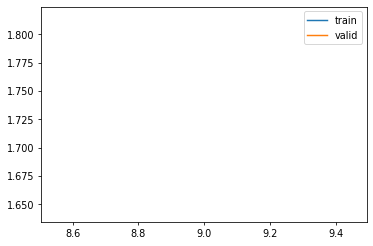

In [146]:
p, t, inp = learn.capture_preds(inps=True)

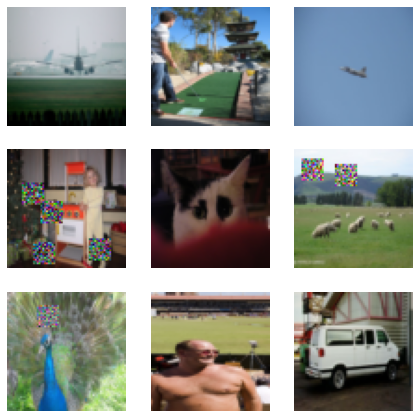

In [147]:
show_images(inp[:9], imsize=2.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


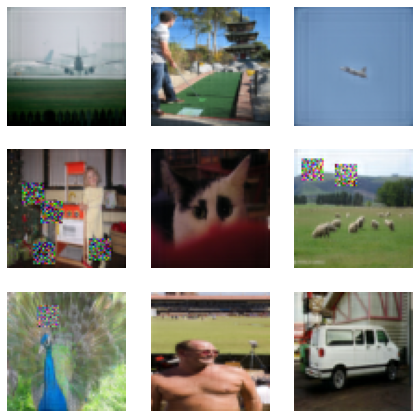

In [148]:
show_images(p[:9], imsize=2.5)

- Weighing the style loss more heavily makes the U-net lose the ability to denoise the image. Need to think of how to fix this.
- Another issue could be that in the UNet, we copy values from previous layers to the current layer. That can hamper style transfer as well.